In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [81]:
IMAGE_PATHS = ["sample_data/logs-1.jpg", "sample_data/logs-2.jpg", "sample_data/logs-3.jpg",
               "sample_data/pipes-1.jpg", "sample_data/pipes-2.jpg", "sample_data/pipes-3.jpg"]
GLOBAL_PARAMS = {
    "RESIZE_WIDTH": 1200,
    # ROI (в относительных координатах)
    "ROI_X1": 0.25,
    "ROI_Y1": 0.01,
    "ROI_X2": 0.90,
    "ROI_Y2": 0.70,

    # Сглаживание
    "MEDIAN_BLUR": 7,
    "GAUSS_BLUR": 3,

    # Параметры HoughCircles
    "DP": 1.3,
    "MIN_DIST": 40,
    "PARAM1": 140,
    "PARAM2": 35,
    "MIN_RADIUS": 10,
    "MAX_RADIUS": 90,
}

# Индивидуальные настройки для конкретных изображений
IMAGE_OVERRIDES = {
    "sample_data/logs-2.jpg": {"ROI_X1": 0.20, "ROI_X2": 0.75, "ROI_Y1": 0.05, "ROI_Y2": 0.7},
    "sample_data/logs-3.jpg": {
        "ROI_X1": 0.10, "ROI_Y1": 0.35, "ROI_X2": 0.35, "ROI_Y2": 0.65,
        "MIN_DIST": 18, "MIN_RADIUS": 6, "MAX_RADIUS": 38,
        "PARAM1":160, "PARAM2": 30,
        },
    "sample_data/pipes-1.jpg": {
        "DP": 1.2,
        "MIN_DIST": 14,
        "PARAM1": 140,
        "PARAM2": 28,
        "MIN_RADIUS": 8,
        "MAX_RADIUS": 35,
        "ROI_X1": 0,
        "ROI_Y1": 0,
        "ROI_X2": 1,
        "ROI_Y2": 1,
    },
    "sample_data/pipes-2.jpg": {
        "DP": 1.2,
        "MIN_DIST": 14,
        "PARAM1": 140,
        "PARAM2": 28,
        "MIN_RADIUS": 8,
        "MAX_RADIUS": 35,
        "ROI_X1": 0,
        "ROI_Y1": 0,
        "ROI_X2": 1,
        "ROI_Y2": 1,
    },
    "sample_data/pipes-3.jpg": {
        "DP": 1.2,
        "MIN_DIST": 28,
        "PARAM1": 110,
        "PARAM2": 42,
        "MIN_RADIUS": 15,
        "MAX_RADIUS": 60,
        "ROI_X1": 0,
        "ROI_Y1": 0,
        "ROI_X2": 1,
        "ROI_Y2": 1,
    },
}

def resolve_params(image_path: str) -> dict:
    """Сливает глобальные параметры с переопределениями для конкретного файла."""
    merged = {**GLOBAL_PARAMS, **IMAGE_OVERRIDES.get(image_path, {})}
    merged["IMAGE_PATH"] = image_path
    return merged


In [19]:
def resize_to_width(img, target_w):
    if target_w <= 0:
        return img
    h, w = img.shape[:2]
    if w == target_w:
        return img
    scale = target_w / w
    return cv.resize(img, (target_w, int(h * scale)), interpolation=cv.INTER_AREA)


def show(img, title=""):
    plt.figure(figsize=(9, 6))
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("on")
    plt.show()

In [72]:
def process_image(IMAGE_PATH):    
    cfg = resolve_params(IMAGE_PATH)
    # Читаем изображение
    img = cv.imread(cfg["IMAGE_PATH"])
    if img is None:
        raise RuntimeError(f"Cannot read image: {cfg['IMAGE_PATH']}")

    # Resize
    img = resize_to_width(img, cfg["RESIZE_WIDTH"])

    # ROI
    h, w = img.shape[:2]
    x1 = int(cfg["ROI_X1"] * w)
    y1 = int(cfg["ROI_Y1"] * h)
    x2 = int(cfg["ROI_X2"] * w)
    y2 = int(cfg["ROI_Y2"] * h)
    roi = img[y1:y2, x1:x2]

    # HSV - V-канал
    hsv = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    V = hsv[:, :, 2]

    # Сглаживание
    if cfg["MEDIAN_BLUR"] > 0:
        V = cv.medianBlur(V, cfg["MEDIAN_BLUR"])
    if cfg["GAUSS_BLUR"] > 0:
        V = cv.GaussianBlur(V, (cfg["GAUSS_BLUR"], cfg["GAUSS_BLUR"]), 0)

    # HoughCircles
    circles = cv.HoughCircles(
        V,
        cv.HOUGH_GRADIENT,
        dp=cfg["DP"],
        minDist=cfg["MIN_DIST"],
        param1=cfg["PARAM1"],
        param2=cfg["PARAM2"],
        minRadius=cfg["MIN_RADIUS"],
        maxRadius=cfg["MAX_RADIUS"],
    )

    # Подсчёт
    count = 0 if circles is None else circles.shape[1]
    print("Количество:", count)

    # Визуализация
    vis = img.copy()
    cv.rectangle(vis, (x1, y1), (x2, y2), (255, 0, 0), 2)

    if circles is not None:
        circles = np.uint16(np.around(circles[0]))
        for x, y, r in circles:
            cv.circle(vis, (x + x1, y + y1), r, (0, 255, 0), 2)
            cv.circle(vis, (x + x1, y + y1), 2, (0, 0, 255), 3)

    show(vis, f"Detected rounds: {count}")

Количество: 67


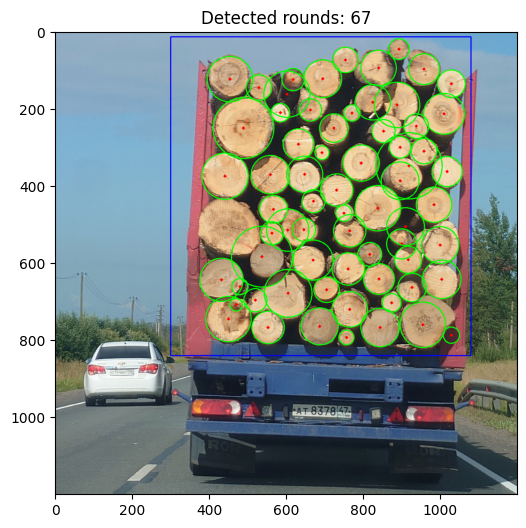

Количество: 66


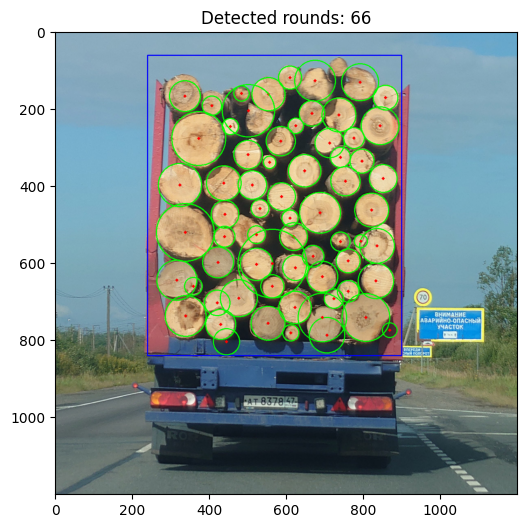

Количество: 37


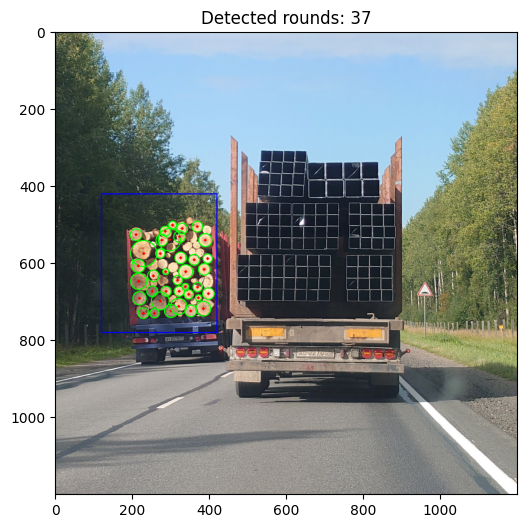

Количество: 95


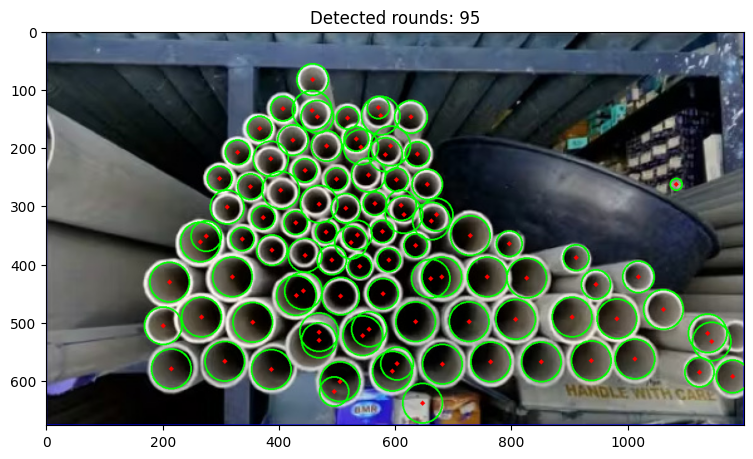

Количество: 143


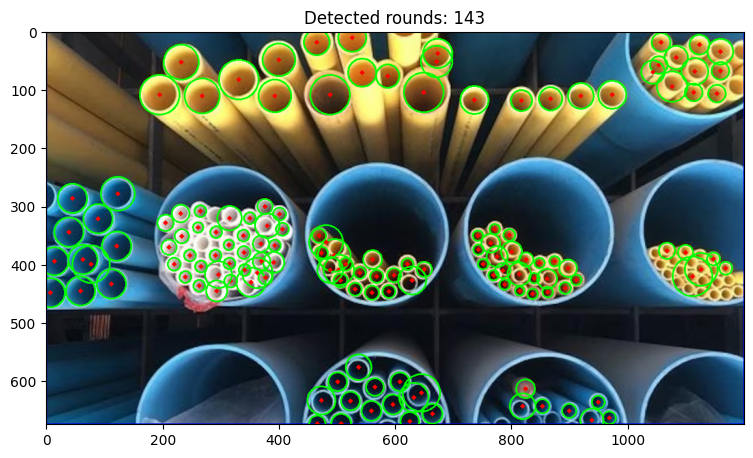

Количество: 64


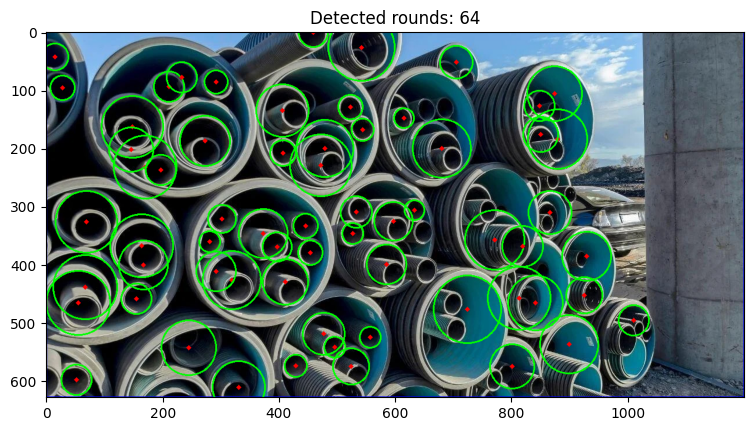

In [82]:
for path in IMAGE_PATHS:
    process_image(path)